In [1]:
# 5-1 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # 데이터 전처리를 위한 라이브러리
from torch.utils.data import Dataset, DataLoader

In [2]:
# 5-2 CPU 혹은 GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download = True,
                                                  transform = transforms.Compose([transforms.ToTensor()]))
# torchvision.dataset(내려받을 위치, 데이터셋 있는지 확인 후 다운로드, 이미지를 텐서로 변경)
test_dataset = torchvision.datasets.FashionMNIST("../chap05/data", download=True,
                                                train=False, transform=transforms.Compose([transforms.ToTensor()]))
# 테스트 데이터셋 내려받음

100%|██████████| 26.4M/26.4M [00:01<00:00, 21.0MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 341kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 6.12MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 13.9MB/s]


In [4]:
# 5-4 fashion_mnist 데이터를 데이터로더에 저장

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100)
# 원하는 크기의 배치 단위로 데이터 불러오기/shuffle
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)

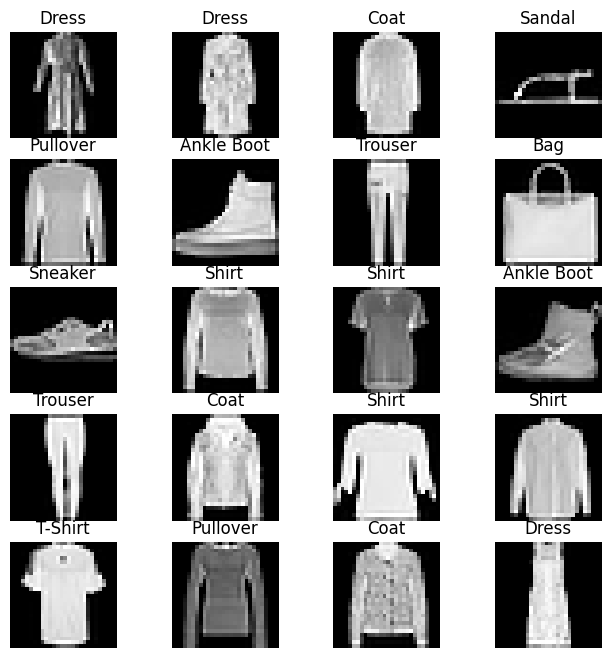

In [5]:
# 5-5 분류에 사용될 클래스 정의

labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
              5 : 'Sandal', 6 : 'Shirt', 7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8)); # 출력할 이미지의 길이(inch)
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
  img_xy = np.random.randint(len(train_dataset)); # 무작위 데이터 생성
  img = train_dataset[img_xy][0][0, :, :] # train_dataset으로 3차원 배열 생성
  fig.add_subplot(rows, columns, i)
  plt.title(labels_map[train_dataset[img_xy][1]])
  plt.axis('off')
  plt.imshow(img, cmap='gray')
plt.show() # 20개의 이미지 데이터를 시각적으로 표현

In [6]:
# random 함수 예시
import numpy as np
print(np.random.randint(10)) # 0~10의 임의의 숫자 출력

print(np.random.randint(1, 10)) # 1~9 임의의 숫자 출력

print(np.random.rand(8)) # 0~1 사이의 정규표준분포 난수를 행렬(1X8)로 출력

print(np.random.rand(4, 2)) # 0~1 사이 정규표준분포 난수를 행렬(4X2)로 출력

print(np.random.rand(8)) # 평균이 0, 표준편차 1인 가우시안 정규분포 난수를 행렬(1X8)로 출력

print(np.random.rand(4, 2)) # 평균이 0, 표준편차 1인 가우시안 ~ (4x2)

7
3
[0.33981392 0.99806343 0.37526951 0.83751942 0.07253309 0.17167258
 0.39045127 0.62586213]
[[0.22716915 0.48450122]
 [0.49313708 0.92911187]
 [0.78382519 0.70662983]
 [0.09296407 0.38697108]]
[0.79371621 0.14399854 0.7770041  0.99233484 0.101415   0.45948292
 0.43927052 0.27535574]
[[0.46492527 0.79614964]
 [0.3266238  0.34742799]
 [0.19059479 0.939585  ]
 [0.50261988 0.91576834]]


In [7]:
# 배열에 대한 사용

import numpy as np
examp = np.arange(0, 100, 3) # 1~99 사이 숫자에서 3씩 건너뛴 행렬 생성
examp.resize(6,4) # 행렬의 크기를 6x4로 조정
print('examp: ',examp)

print('examp[3]: ', examp[3]) # 3행에 해당하는 모든 요소 출력

print('examp[3, 3]: ', examp[3, 3]) # 3행의 3번째 열에 대한 값 출력

print('examp[3][3]', examp[3][3]) # 3행의 3번째 열에 대한 요소 출력

examp = np.arange(0, 500, 3)
examp.resize(3, 5, 5)
print('examp: ',examp)
print(examp[2][0][3])

examp:  [[ 0  3  6  9]
 [12 15 18 21]
 [24 27 30 33]
 [36 39 42 45]
 [48 51 54 57]
 [60 63 66 69]]
examp[3]:  [36 39 42 45]
examp[3, 3]:  45
examp[3][3] 45
examp:  [[[  0   3   6   9  12]
  [ 15  18  21  24  27]
  [ 30  33  36  39  42]
  [ 45  48  51  54  57]
  [ 60  63  66  69  72]]

 [[ 75  78  81  84  87]
  [ 90  93  96  99 102]
  [105 108 111 114 117]
  [120 123 126 129 132]
  [135 138 141 144 147]]

 [[150 153 156 159 162]
  [165 168 171 174 177]
  [180 183 186 189 192]
  [195 198 201 204 207]
  [210 213 216 219 222]]]
159


In [8]:
# 5-6 심층 신경망 모델 생성

class FashionDNN(nn.Module):
  def __init__(self):
  # 클래스 형태 모델은 항상 torch.nn.Module 상속받음
  # __init__()은 객체가 갖는 속성 값을 초기화, 객체 생성시 자동 호출
    super(FashionDNN, self).__init__()
    self.fc1 = nn.Linear(in_features=784, out_features=256)
    # nn-딥러닝 모델 구성에 필요한 모듈 패키지
    # Linear-단순 선형 회귀 모델
    # nn.Linear(입력 크기, 출력 크기)
    self.drop = nn.Dropout(0.25) # p만큼의 비율로 텐서의 값이 0됨, not0는 기존값*(1/(1-p))
    self.fc2 = nn.Linear(in_features=256, out_features=128)
    self.fc3 = nn.Linear(in_features=128, out_features=10)

  def forward(self, input_data): # forward()-데이터 받아서 순전파 학습 진행
    out = input_data.view(-1, 784) # view-numpy의 reshape 역할
    out = F.relu(self.fc1(out)) # 활성화 함수 지정 방법 [1]F.relu() [2]nn.ReLU()
    out = self.drop(out)
    out = F.relu(self.fc2(out))
    out = self.fc3(out)
    return out

In [9]:
# 5-7 심층 신경망에서 필요한 파라미터 정의

learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss(); # 분류 문제에서 사용하는 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
# 옵티마이저를 위한 경사 하강법 - Adam, lr-학습률
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
# 5-8 심층 신경망을 이용한 모델 학습
num_epochs = 5
count = 0
loss_list = [] # list 사용법1: 비어있는 배열 or 행렬 만듦
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader : # 레코드(행, 가로줄) 하나씩 가져옴
    images, labels = images.to(device), labels.to(device) # 모델과 데이터가 동일한 장치에(CPU/GPU)

    train = Variable(images.view(100, 1, 28, 28)) #Autograd-자동미분
    # Variable사용해서 역전파를 위한 미분값 자동 계산
    labels = Variable(labels)

    outputs = model(train) # 학습 데이터를 모델에 적용
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not (count % 50): # count를 50으로 나누었을 때 나머지가 0이 아니라면 실행
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total # 분류 문제에 대한 정확도: 정확한 예측/전체 예측
      loss_list.append(loss.data) # list 사용법2: append 메서드 이용하여 데이터 하나씩 추가
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, loss: 0.6130635738372803, Accuracy: 82.97000122070312%
Iteration: 1000, loss: 0.49893325567245483, Accuracy: 84.2699966430664%
Iteration: 1500, loss: 0.36085379123687744, Accuracy: 84.5199966430664%
Iteration: 2000, loss: 0.393596887588501, Accuracy: 85.69000244140625%
Iteration: 2500, loss: 0.2704679071903229, Accuracy: 86.19999694824219%
Iteration: 3000, loss: 0.309175580739975, Accuracy: 86.5199966430664%


In [11]:
# 5-9 합성곱 네트워크 생성

class FashionCNN(nn.Module):
  def __init__(self):
    super(FashionCNN, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2)
    )
    self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
    self.drop = nn.Dropout2d(0.25)
    self.fc2 = nn.Linear(in_features=600, out_features=120)
    self.fc3 = nn.Linear(in_features=120, out_features=10) # 마지막 계층의 out_features=클래스 개수

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.drop(out)
    out = self.fc2(out)
    out = self.fc3(out)
    return out


In [12]:
# 5-10 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
# 5-11 모델 학습 및 성능 평가

num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
predictions_list = []
labels_list = []

for epoch in range(num_epochs):
  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    train = Variable(images.view(100, 1, 28, 28))
    labels = Variable(labels)

    outputs = model(train)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    count += 1

    if not(count % 50):
      total = 0
      correct = 0
      for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        labels_list.append(labels)
        test = Variable(images.view(100, 1, 28, 28))
        outputs = model(test)
        predictions = torch.max(outputs, 1)[1].to(device)
        predictions_list.append(predictions)
        correct += (predictions == labels).sum()
        total += len(labels)

      accuracy = correct * 100 / total
      loss_list.append(loss.data)
      iteration_list.append(count)
      accuracy_list.append(accuracy)

    if not (count % 500):
      print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:1535: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.5177029967308044, Accuracy: 87.95999908447266%
Iteration: 1000, Loss: 0.28837350010871887, Accuracy: 89.1500015258789%
Iteration: 1500, Loss: 0.25163283944129944, Accuracy: 86.87999725341797%
Iteration: 2000, Loss: 0.17873553931713104, Accuracy: 89.29000091552734%
Iteration: 2500, Loss: 0.18259267508983612, Accuracy: 90.20999908447266%
Iteration: 3000, Loss: 0.22775918245315552, Accuracy: 89.93000030517578%
